In [1]:
import numpy as np
from tqdm import tqdm
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [2]:
monthly = pd.read_csv("frontier/monthlyinc1000.txt", names=['slot', 'value', 'inserted_at', 'pk'], delimiter='|')
monthly['inserted_at'] = pd.to_datetime(monthly['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
monthly.head()

,slot,value,inserted_at,pk
0,5877441,4100751565914457,2023-02-25 19:28:24.879946,0xa1ee9e
1,5877441,3666426134683254,2023-02-25 19:28:25.068712,0xaa1488
2,5877441,4205695161447457,2023-02-25 19:28:25.138228,0xa1ee9e
3,5877441,4304797161447457,2023-02-25 19:28:25.403391,0xa1ee9e
4,5877441,3771369730216254,2023-02-25 19:28:25.414058,0xa85807


In [3]:
len(monthly)

72255

In [4]:
slots = list(set(monthly['slot'].values))
pks = list(set(monthly['pk'].values))
len(slots), len(pks)

(98, 70)

In [5]:
pkWeiPerMus = {}
for p in pks:
    pkWeiPerMus[p] = []

for sl in tqdm(slots[:]):
    slotdf = monthly[monthly['slot']==sl]
    for pk in pks[:]:
        pkdf = slotdf[slotdf['pk']==pk]
        diffsTime = np.asarray([v.total_seconds() * 1000000 for v in pkdf['inserted_at'].diff()])
        diffsVal = np.asarray([v for v in pkdf['value'].diff()])
        for i in range(1, len(diffsTime)):
            if diffsTime[i] <= 0:
                raise ValueError("negative time diff")
            if diffsVal[i] < 0:
                continue
            pkWeiPerMus[pk].append(diffsVal[i] / diffsTime[i])

100%|██████████| 98/98 [00:06<00:00, 15.91it/s]


In [13]:
total = []
for k in pkWeiPerMus.keys():
    total.extend(pkWeiPerMus[k])
total = np.asarray(total)
total.shape

(58596,)

In [14]:
# total_plt = total[total > np.percentile(total, 5)]
total_plt = total[total < np.percentile(total, 95)]
total_plt.shape

(55666,)

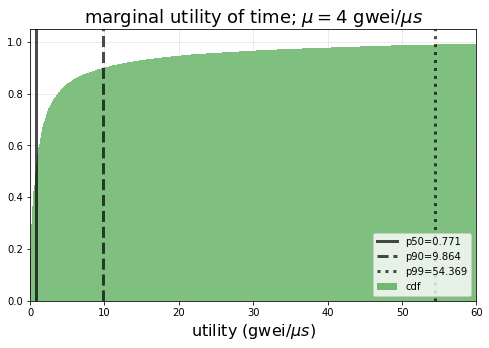

In [58]:
f, ax = plt.subplots(figsize=(8,5))
percs = [(int(i*100), np.quantile(total_plt/int(1e9), i)) for i in [.50, .90, .99]]

ax.hist(total_plt/int(1e9), bins=1000, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(0,60)
ax.set_xlabel('utility (gwei/$\mu s$)', size=16)
ax.set_title('marginal utility of time; $\mu={:0.0f}$ gwei$/\mu s$'.format(total_plt.mean()/int(1e9)), size=18)
plt.legend(loc=4)
plt.show()

In [82]:
percs("gwei per \mu s", total/int(1e9))

gwei per \mu s & 0 & 3 & 20 & 74 & 961 & 19693 \\


In [81]:
def percs(label, arr):
    print('{} & '.format(label), end='')
    st = ''
    for i in [.50, .75, .90, 0.95, .99, .999]:
        st += str(int(np.quantile(arr, i)))
        st += " & "
    print(st[:-3] + ' \\\\')

## winner submission times

In [48]:
mwins = pd.read_csv("frontier/winningrecvd.txt", names=['slot', 'bh', 'received_at', 'eligible_at'], delimiter='|')
mwins['received_at'] = pd.to_datetime(mwins['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins['eligible_at'] = pd.to_datetime(mwins['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [49]:
len(mwins)

31273

In [50]:
mwins = mwins.sort_values('eligible_at', ascending=True).drop_duplicates('slot').sort_index()
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [51]:
len(mwins)

27397

In [52]:
mwins['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in mwins['received_at'].values])
mwins['diff'] = [v.total_seconds() for v in mwins['slot_boundary'] - mwins['received_at']]
mwins.head()

,slot,bh,received_at,eligible_at,slot_boundary,diff
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520,2023-03-13 17:52:12,0.516928
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869,2023-03-13 17:52:24,-0.239075
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399,2023-03-13 17:53:24,1.148058
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045,2023-03-13 17:53:48,0.897021
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660,2023-03-13 17:54:12,1.064122


In [65]:
percs = [(int(i*100), np.quantile(mwins['diff'], i)) for i in [.50, .90, .99]]
percs

[(50, 0.864746), (90, 1.3146894000000002), (99, 1.8900897600000028)]

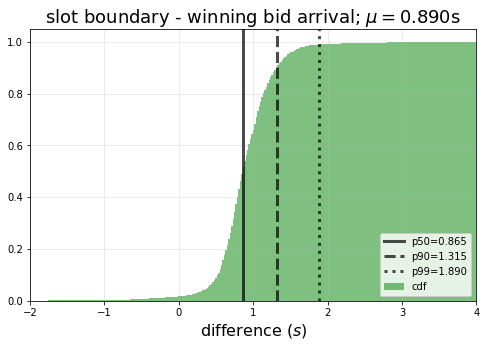

In [66]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(mwins['diff'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(mwins['diff'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(-2,4)
ax.set_xlabel('difference $(s)$', size=16)
ax.set_title('slot boundary - winning bid arrival; $\mu={:0.3f}$s'.format(mwins['diff'].mean()), size=18)
plt.legend(loc=4)
plt.show()

## simulation durations 

In [30]:
nopts = pd.read_csv('rollout/big/noptsubs.txt', delimiter="|")
nopts['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
nopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807


In [31]:
len(nopts)

1000000

In [32]:
12410 + 1786 + 75578 + 6903

96677

In [33]:
nopts_plot = nopts[nopts['total_duration'] < np.quantile(nopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

In [34]:
np.quantile(nopts['simulation_duration'].values, 0.999)

1592421.026000001

In [32]:
nopts['decode_duration'].mean(), nopts['prechecks_duration'].mean(),nopts['simulation_duration'].mean(),nopts['redis_update_duration'].mean()

(73041.164332, 17930.121351, 142992.88085, 35826.475345)

In [56]:
yopts['redis_update_duration'].mean(), yopts['redis_update_duration'].mean() / yopts['total_duration'].mean(), 

(25923.84881855749, 0.26330497914869067)

In [57]:
73041.164332 + 17930.121351 + 142992.88085 + 35826.475345

269790.641878

In [58]:
yopts['total_duration'].mean()

98455.59663312732

In [59]:
yopts['decode_duration'].mean(), yopts['prechecks_duration'].mean(),yopts['simulation_duration'].mean(),yopts['redis_update_duration'].mean()

(53252.13336907648, 19247.562639861502, 30.55739570621766, 25923.84881855749)

In [60]:
yopts['total_duration'].mean()

98455.59663312732

In [61]:
53252.13336907648 + 19247.562639861502 + 30.55739570621766 + 25923.84881855749

98454.10222320168

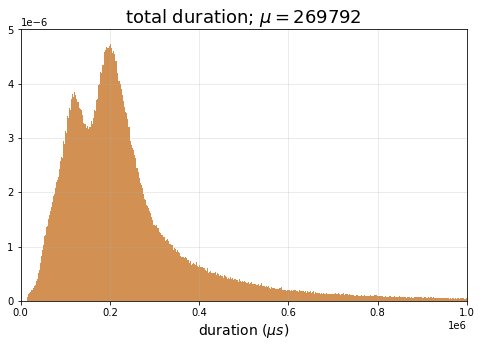

In [35]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(nopts_plot['total_duration'], bins=1000)[1]
# ax.hist(nopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
#         label='simulation duration $(\mu = {:0.0f})$'.format(nopts['simulation_duration'].values.mean()))
ax.hist(nopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(nopts['total_duration'].values.mean()))
ax.set_xlim(0, int(1e6))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
ax.set_title('total duration; $\mu = {:0.0f}$'.format(nopts['total_duration'].values.mean()), size=18)
plt.show()

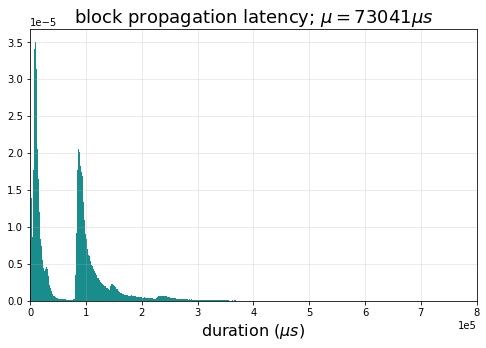

In [62]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(nopts_plot['decode_duration'], bins=1000)[1]
# ax.hist(nopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
#         label='simulation duration $(\mu = {:0.0f})$'.format(nopts['simulation_duration'].values.mean()))
ax.hist(nopts_plot['decode_duration'], bins=bins, color='teal', alpha=0.9, density=True, 
        label='block propagation latency $(\mu = {:0.0f})$'.format(nopts['decode_duration'].values.mean()))
ax.set_xlim(0, int(8e5))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=16)
# ax.set_title('non-optimistic block submission durations', size=16)
ax.set_title('block propagation latency; $\mu = {:0.0f} \mu s$'.format(nopts['decode_duration'].values.mean()), size=18)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

In [47]:
nopts[nopts['decode_duration'] < 75000]['decode_duration'].mean()

13625.140963068376

In [51]:
nopts[nopts['decode_duration'] > 75000][nopts['decode_duration'] < 200000]['decode_duration'].mean()

<ipython-input-51-5eeb003bb764>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nopts[nopts['decode_duration'] > 75000][nopts['decode_duration'] < 200000]['decode_duration'].mean()


106997.97334487914

In [49]:
122575.59905308344/13625.140963068376

8.996281167683382

In [191]:
len(nopts[nopts['simulation_duration'] > int(1e6)]) / len(nopts) 

0.004962

In [60]:
percs = [(int(i*100), np.quantile(nopts['simulation_duration'], i)) for i in [.50, .90, .99]]
percs

[(50, 113377.0), (90, 218973.0), (99, 744570.2900000003)]

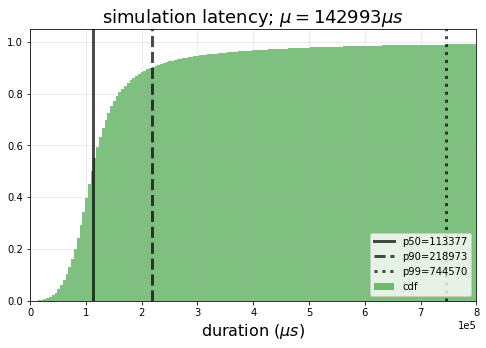

In [61]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(nopts['simulation_duration'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(nopts['simulation_duration'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)
ax.set_xlim(0,int(8e5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel('duration $(\mu s)$', size=16)
ax.set_title('simulation latency; $\mu={:0.0f} \mu s$'.format(nopts['simulation_duration'].mean()), size=18)
plt.legend(loc=4)
plt.show()

## opt submissions

In [52]:
yopts = pd.read_csv('rollout/big/optsubs.txt', delimiter="|")
yopts['received_at'] = pd.to_datetime(yopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
yopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349


In [53]:
len(yopts)

912063

In [54]:
12062 + 11 + 5999 + 1407

19479

In [55]:
yopts_plot = yopts[yopts['total_duration'] < np.quantile(yopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

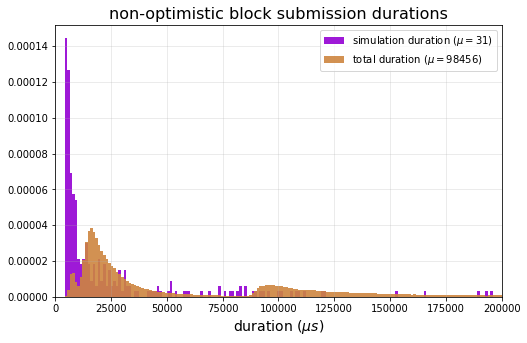

In [161]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(yopts_plot['total_duration'], bins=1000)[1]
ax.hist(yopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
        label='simulation duration $(\mu = {:0.0f})$'.format(yopts['simulation_duration'].values.mean()))
ax.hist(yopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(yopts['total_duration'].values.mean()))
ax.set_xlim(0, int(2e5))
ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('non-optimistic block submission durations', size=16)
plt.show()

## block size & latency

In [2]:
pdurs = pd.read_csv('frontier/payload_durs.txt', delimiter='|', names=['bytes', 'decode_duration', 'pubkey'])
pdurs.head()

,bytes,decode_duration,pubkey
0,55660,12369,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...
1,52714,31733,0x83d3495a2951065cf19c4d282afca0a635a39f6504bd...
2,56012,10890,0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...
3,53879,124424,0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25...
4,51754,255603,0x8cb3cb2fdc996d14bf30bc56c94d93f250245cfd4578...


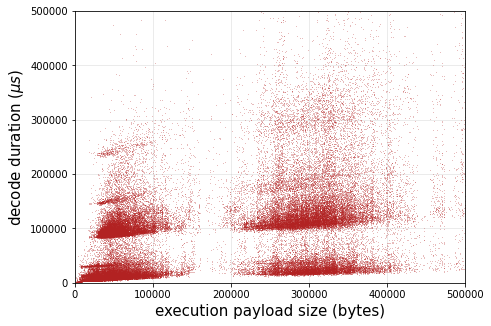

In [3]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(pdurs['bytes'], pdurs['decode_duration'], color='firebrick', marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(5e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [4]:
tops = pdurs['pubkey'].value_counts()[:10].index
tops

Index(['0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25ab61b969a2af24b61508783ceb48175ef252ec9f82c6cdf8d8fd',
       '0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587',
       '0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08',
       '0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f18c12a6171400eb6e04d49238ba2b0a95e633d15558e6a706fbe4',
       '0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27',
       '0x83d3495a2951065cf19c4d282afca0a635a39f6504bd76282ed0138fe28680ec60fa3fd149e6d27a94a7d90e7b1fb640',
       '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
       '0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d053be613f469a48f7416999a4da35dd60a7824478661399e6772',
       '0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06b7a020304099c23d2d9952d4254cc50f291c385d15e7cae0cf9d',
       '0xb194b2b8e

In [5]:
pk_durs = {}
for i in tops:
    pk_durs[i] = pdurs[pdurs['pubkey']==i]

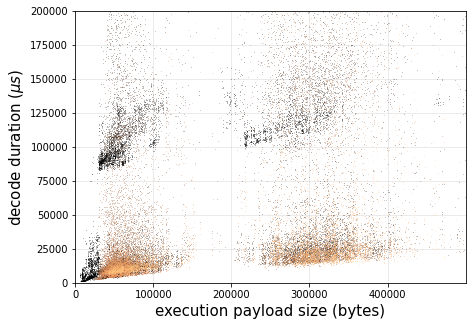

In [6]:
f, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.copper(np.linspace(0, 1, 10))
for i,pk in enumerate(pk_durs):
    val = pk_durs[pk]
    ax.plot(val['bytes'], val['decode_duration'], color=colors[i], marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(2e5))
ax.set_xlim(0, int(5e5))
ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [7]:
tops[2]

'0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08'

In [8]:
tops[1]

'0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587'

In [22]:
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
reg.score(X,y)
reg.coef_, reg.intercept_

(array([0.21308517]), -8002.659109032313)

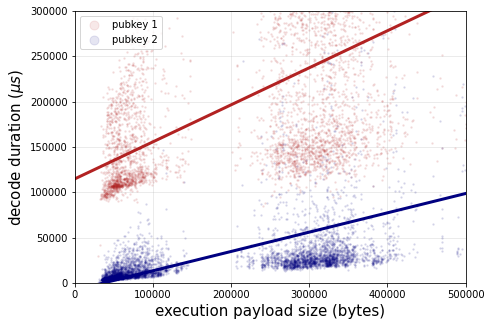

In [26]:
f, ax = plt.subplots(figsize=(7,5))
# colors = plt.cm.copper(np.linspace(0, 1, 10))
val = pk_durs[tops[2]]
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
# reg.score(X,y)
reg.coef_, reg.intercept_
ax.plot(np.arange(0, 500000) * reg.coef_ + reg.intercept_, color='firebrick', linewidth=3)
ax.plot(val['bytes'], val['decode_duration'], color='firebrick', marker='.', alpha=0.1, linestyle='None', 
        markersize=3, label='pubkey 1')

val = pk_durs[tops[1]]
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
# reg.score(X,y)
reg.coef_, reg.intercept_
ax.plot(np.arange(0, 500000) * reg.coef_ + reg.intercept_, color='navy', linewidth=3)
ax.plot(val['bytes'], val['decode_duration'], color='navy', marker='.', alpha=0.1, linestyle='None', 
        markersize=3, label='pubkey 2')
ax.set_ylim(0, int(3e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
lgnd = ax.legend(markerscale=6)
plt.show()

In [265]:
pk1 = pk_durs[tops[2]]
pk2 = pk_durs[tops[1]]

In [266]:
normalized1 = pk1['decode_duration'] / pk1['bytes']
normalized2 = pk2['decode_duration'] / pk2['bytes']

In [274]:
normalized1.mean()

1.32258861178476

In [273]:
normalized2.mean()

0.17164546399480177

In [267]:
len(normalized1), len(normalized2)

(4280, 5133)

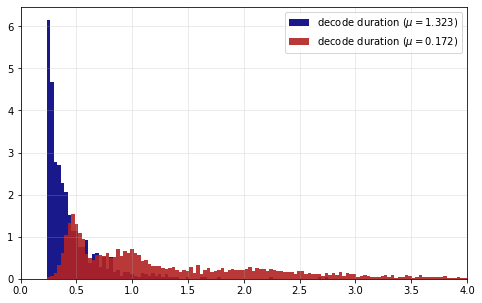

In [276]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(normalized1, bins=300)[1]
ax.hist(normalized2, bins=bins, color='navy', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized1.mean()))
ax.hist(normalized1, bins=bins, color='firebrick', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized2.mean()))
ax.set_xlim(0, 4)
ax.legend(loc=0)
# ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
plt.show()

## compare single builder

In [73]:
start = 6100517
end = 5999717 # 14 days ago
payload = {
    'builder_pubkey': '0xb194b2b8ec91a71c18f8483825234679299d146495a08db3bf3fb955e1d85a5fca77e88de93a74f4e32320fc922d3027',
}
total_df = pd.DataFrame()
while start > end:
    print('start={}'.format(start))
    payload['cursor'] = start
    r = requests.get(
#         'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://agnostic-relay.net/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    total_df = total_df.append(out_df)
    total_df = total_df.sort_values('slot').reset_index(drop=True)
    start = int(total_df['slot'].min())
len(total_df)

start=6100517
start=6082372
start=6071644
start=6058748
start=6045583
start=6034920
start=6022398
start=6009294


1600

In [75]:
# fbs = total_df
fbs.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5994935,0xd929a045b56d9ddae03400f6598eaa6a09e806839f39...,0x1e54f20dfc520ce4cbf56bcbde031f4cddc163d7977e...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xa75f1ae5b77603494c71377a3f159d16f70c81674d90...,0x4675c7e5baafbffbca748158becba61ef3b0a263,30000000,16044773,412502542411688249,140,16823415
1,5994955,0xd59f4fd112688086fcb7b592c539112b6afb380bc468...,0x1cc5d4814ba57ec547deb8113efd920f39e4dad0723f...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xb8b277ccbcb0b85bbbcb38de42c031337f8840bab914...,0x4675c7e5baafbffbca748158becba61ef3b0a263,30000000,11032899,27426987887121338,103,16823434
2,5994962,0x3797caaf25420f51975d3da334fa49122f059605e087...,0x23b2741fb9f4fa50e668c21979f718bf15620dfbe1b2...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x947c37888ecb8b16c4c7d29253f0d353c46fe2a24e10...,0xadae1798f761fa7fce29b6673d453d1a48a2931a,30000000,12771455,47840137646090635,130,16823441
3,5995043,0x5f126cc178be25d83b9f90c76ac719ccb5c65d2d7ec8...,0xe40bde108945c8184aeff36e0146c4e330509150eb56...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x927b5dd181a1c063dc1fce3db1cdcd8f504df95bdadc...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,15561729,57625883334391253,182,16823521
4,5995048,0xbc651f4884a43a6a5880ccb6ccf567a272f7bd1eff39...,0xcf3d1e9bfcea4119195a9db5f3083bd6010d7211809a...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xa7bb7a5e1f4595456a1258b9d0f775d4199a80e09ca8...,0x4e9cc05f7f944d618de85396e669922c2cf6813e,30000000,11167279,49169925536058891,134,16823526


In [72]:
# agn = total_df
agn.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5992184,0x0f726a5992e2224418eb937ff504b23d2276eb6eeec4...,0x5249fd223702c41990b711a462e76b6b902467396c4c...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x96d50e1f22b3db9953b795f5adf8aa9b130666916f08...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,25034326,482899221788625971,215,16820693
1,5992306,0x845e8d5fb9fcbacd6e4cd7ba0a4bfaa29e945d200b0a...,0xb5aeebf7a5347822fd605e1900baa2387ed65cfb8289...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xb6b7215fc1b4ced0cb6dc19a50abd89249015ad31e8e...,0xebec795c9c8bbd61ffc14a6662944748f299cacf,30000000,14840215,173808637476014743,158,16820815
2,5992389,0x4483a0a448083389c08c7065c4c304c1829ad59ebb27...,0x0de8910900bdab730b055e195905394f32933aa41f22...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x948e318e8091a283dfa4ad12ade1adc7a80a4b5b6f7e...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14227521,52439484120006527,146,16820898
3,5992404,0xa904b30cf051632279da9a590c180c93cf3dc5759f92...,0x451493aa65a0a8f8d07a4a51b6038a36d9c60485601c...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xa5bdea976cf0260a5b6c8732dc6e28a44d6007d1c035...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14769451,50569531337484509,145,16820913
4,5992457,0x1b1336041c950d8a7e513ba746e75057fd1d4db36ce1...,0x1d6fca4f124f000566ea47105ab74f04c8f0daf37af1...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xae12c7c5ecf773b749dc243a7e9068db1b6dc183e8bb...,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,30000000,14324633,1990127884769134073,149,16820966


In [68]:
# usr = total_df
usr.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5991283,0x480e42d1aa78088090b4ea3fcb135a804f48439f9a53...,0x52384f2c7c0f1a31cea444d4e8e0f40d5c8f999e3c7c...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xac95bf5d4f6553c2ed154da97505dcba883b8b6ead36...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14144544,1032241691943322984,145,16819803
1,5991314,0x98d80977c4cd28b5443e9c4e112fc7314f60506866a9...,0xaa3212fa061a3890482ece0941fe52e7efacfcc5900e...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8647aa613b3389b8766dbda66337ad3adb086118cc5b...,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,30000000,18479976,380530265510846604,180,16819834
2,5991353,0x1f067e92d6de0f6015b9764e64cbd45420266de1571b...,0x19206a643153c9a8aa836630de3f2680c727298ba225...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x910056c31d2e2be7139a2217b013b8aae5428cffec65...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,12932371,298298206122585183,145,16819873
3,5991396,0xb0b6f505a9685ec283ddaad2bfdf89d60ed7d5858bcf...,0xf116d8e4d5bd0f3f8605528402757ff2e40da58ca779...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8aa2ffa79109ab6c3406054c2a5d38e0295592134f4d...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,26326049,302479987814998012,223,16819914
4,5991419,0xdcf7722eaca7b4063944265e70f6b214f2ae1b1b119b...,0xb74852ad3478bd5ede225dbaa5ec9e73f938f46a6ac1...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x864fdf3e347362d53e56416a9b90583afe6bc23c8a0b...,0x72a12caefc60ed89b87c2efcbce700e4a3fa9775,30000000,29978354,841100450029719214,328,16819937


In [78]:
len(fbs), len(agn), len(usr)

(1600, 1400, 2600)

In [79]:
fbs['slot'] = pd.to_numeric(fbs['slot'])
agn['slot'] = pd.to_numeric(agn['slot'])
usr['slot'] = pd.to_numeric(usr['slot'])
fbs['value'] = fbs['value'].astype(float)
agn['value'] = agn['value'].astype(float)
usr['value'] = usr['value'].astype(float)

In [81]:
start = 6100517
end = 5999717 
hourly = np.arange(end, start, 900)

fbs_hourly = []
agn_hourly = []
usr_hourly = []
for i in range(1,len(hourly)):
    lb, ub = hourly[i-1], hourly[i]
#     print(lb,ub)
    fbs_hourly.append(len(fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]))
    agn_hourly.append(len(agn[(agn['slot'] >= lb) & (agn['slot'] < ub)]))
    usr_hourly.append(len(usr[(usr['slot'] >= lb) & (usr['slot'] < ub)]))
fbs_hourly = np.asarray(fbs_hourly)
agn_hourly = np.asarray(agn_hourly)
usr_hourly = np.asarray(usr_hourly)

In [83]:
len(fbs_hourly), len(agn_hourly), len(usr_hourly), len(hourly)

(111, 111, 111, 112)

In [86]:
out = pd.DataFrame()
out['start_slot'] = hourly[1:]
out['fbs'] = fbs_hourly
out['agn'] = agn_hourly
out['usr'] = usr_hourly

In [90]:
out.tail()

,start_slot,fbs,agn,usr
106,6096017,8,7,10
107,6096917,11,9,10
108,6097817,6,10,4
109,6098717,7,9,7
110,6099617,6,6,11


In [89]:
out.to_csv("hourly.csv")

In [ ]:
start = 6100517
end = 5999717 
hourly = np.arange(end, start, 300)

fbs_hourly_v = []
agn_hourly_v = []
usr_hourly_v = []
for i in range(1,len(hourly)):
    lb, ub = hourly[i-1], hourly[i]
    sub = fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]
    fbs_hourly_v.append([
        fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]['value']
    agn_hourly_v.append(len(agn[(agn['slot'] >= lb) & (agn['slot'] < ub)]))
    usr_hourly_v.append(len(usr[(usr['slot'] >= lb) & (usr['slot'] < ub)]))
fbs_hourly = np.asarray(fbs_hourly)
agn_hourly = np.asarray(agn_hourly)
usr_hourly = np.asarray(usr_hourly)

In [135]:
len(hourly)

336

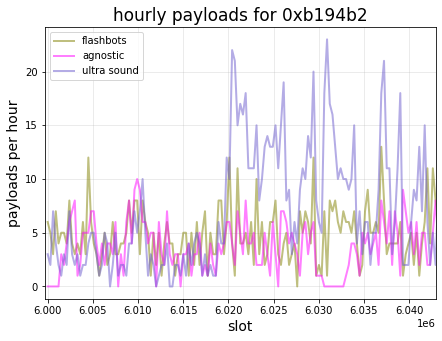

In [154]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(hourly[1:], fbs_hourly, linewidth=2, color='olive', label='flashbots', alpha=0.5)
ax.plot(hourly[1:], agn_hourly, linewidth=2, color='fuchsia', label='agnostic', alpha=0.5)
ax.plot(hourly[1:], usr_hourly, linewidth=2, color='slateblue', label='ultra sound', alpha=0.5)
ax.set_xlim(5999717, 5999717+7200*6)
ax.legend()
ax.set_xlabel('slot', size=14)
ax.set_ylabel('payloads per hour', size=14)
ax.set_title('hourly payloads for 0xb194b2', size=17)
plt.show()

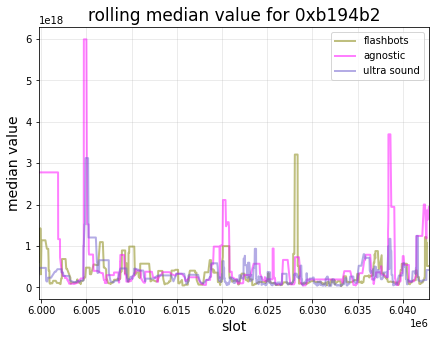

In [167]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(fbs['slot'], fbs['value'].rolling(10).quantile(0.9), linewidth=2, color='olive', label='flashbots', alpha=0.5)
ax.plot(agn['slot'], agn['value'].rolling(10).quantile(0.9), linewidth=2, color='fuchsia', label='agnostic', alpha=0.5)
ax.plot(usr['slot'], usr['value'].rolling(10).quantile(0.9), linewidth=2, color='slateblue', label='ultra sound', alpha=0.5)
ax.set_xlim(5999717, 5999717+7200*6)
# ax.set_ylim(0, int(1e18))
ax.legend()
ax.set_xlabel('slot', size=14)
ax.set_ylabel('median value', size=14)
ax.set_title('rolling median value for 0xb194b2', size=17)
plt.show()

## builder within slot

In [2]:
start = 6100517
end = 5999717 # 14 days ago
payload = {
    'builder_pubkey': '0xb194b2b8ec91a71c18f8483825234679299d146495a08db3bf3fb955e1d85a5fca77e88de93a74f4e32320fc922d3027',
}
total_df = pd.DataFrame()
while start > end:
    print('start={}'.format(start))
    payload['cursor'] = start
    r = requests.get(
        'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://agnostic-relay.net/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    total_df = total_df.append(out_df)
    total_df = total_df.sort_values('slot').reset_index(drop=True)
    start = int(total_df['slot'].min())
len(total_df)

start=6100517
start=6087458
start=6081459
start=6075112
start=6068116
start=6062130
start=6056483
start=6046974
start=6038569
start=6031809
start=6026451
start=6021720
start=6010254


2600

In [3]:
usr = total_df
usr.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5991283,0x480e42d1aa78088090b4ea3fcb135a804f48439f9a53...,0x52384f2c7c0f1a31cea444d4e8e0f40d5c8f999e3c7c...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xac95bf5d4f6553c2ed154da97505dcba883b8b6ead36...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14144544,1032241691943322984,145,16819803
1,5991314,0x98d80977c4cd28b5443e9c4e112fc7314f60506866a9...,0xaa3212fa061a3890482ece0941fe52e7efacfcc5900e...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8647aa613b3389b8766dbda66337ad3adb086118cc5b...,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,30000000,18479976,380530265510846604,180,16819834
2,5991353,0x1f067e92d6de0f6015b9764e64cbd45420266de1571b...,0x19206a643153c9a8aa836630de3f2680c727298ba225...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x910056c31d2e2be7139a2217b013b8aae5428cffec65...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,12932371,298298206122585183,145,16819873
3,5991396,0xb0b6f505a9685ec283ddaad2bfdf89d60ed7d5858bcf...,0xf116d8e4d5bd0f3f8605528402757ff2e40da58ca779...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8aa2ffa79109ab6c3406054c2a5d38e0295592134f4d...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,26326049,302479987814998012,223,16819914
4,5991419,0xdcf7722eaca7b4063944265e70f6b214f2ae1b1b119b...,0xb74852ad3478bd5ede225dbaa5ec9e73f938f46a6ac1...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x864fdf3e347362d53e56416a9b90583afe6bc23c8a0b...,0x72a12caefc60ed89b87c2efcbce700e4a3fa9775,30000000,29978354,841100450029719214,328,16819937


In [28]:
usr['slot'] = pd.to_numeric(usr['slot'])
usr['value'] = usr['value'].astype(float)

In [4]:
payload = {
    'builder_pubkey': '0xb194b2b8ec91a71c18f8483825234679299d146495a08db3bf3fb955e1d85a5fca77e88de93a74f4e32320fc922d3027',
}
payload['slot'] = 5991283
r = requests.get(
#     'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
    'https://agnostic-relay.net/relay/v1/data/bidtraces/builder_blocks_received',
#     'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
    params=payload
)

In [12]:
total_df = pd.DataFrame()
slots = usr['slot'].values
maxs = []
for s in slots:
    print(s, end='\r')
    payload['slot'] = s
    r = requests.get(
#         'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
        'https://agnostic-relay.net/relay/v1/data/bidtraces/builder_blocks_received',
#         'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    if len(out_df) > 0:
        out_df['value'] = out_df['value'].astype(float)
        maxs.append((s, out_df['value'].values.max()))
maxs = np.asarray(maxs)

In [13]:
agn_maxs = maxs

In [19]:
agn_maxs = agn_maxs.astype(float)
agn_maxs

array([[5.99128300e+06, 1.03852226e+18],
       [5.99131400e+06, 3.84038128e+17],
       [5.99135300e+06, 2.98298206e+17],
       ...,
       [6.10019900e+06, 5.89557457e+16],
       [6.10029600e+06, 2.76412611e+16],
       [6.10044100e+06, 8.18430666e+16]])

In [21]:
agn_maxs[0][0]

5991283.0

In [31]:
usr_maxs = []
for v in agn_maxs:
    slot = v[0]
    usr_maxs.append(usr[usr['slot']==int(slot)]['value'].values.max())
usr_maxs = np.asarray(usr_maxs)
usr_maxs = usr_maxs.astype(float)

In [32]:
usr_maxs

array([1.03224169e+18, 3.80530266e+17, 2.98298206e+17, ...,
       5.83460814e+16, 2.33164045e+16, 8.05813382e+16])

In [34]:
agn_maxs[:,1]

array([1.03852226e+18, 3.84038128e+17, 2.98298206e+17, ...,
       5.89557457e+16, 2.76412611e+16, 8.18430666e+16])

In [35]:
diffs = usr_maxs - agn_maxs[:,1]

In [37]:
len(diffs)

2069

In [46]:
diffs.mean()

-5490683827922150.0

In [45]:
np.quantile(diffs, 0.99)

0.0

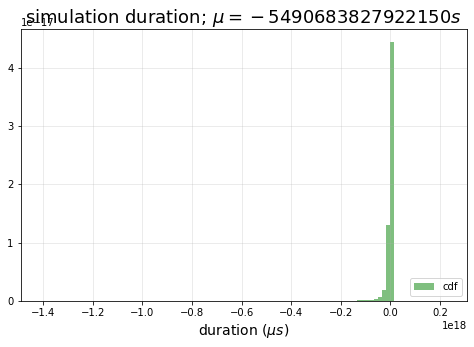

In [40]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(diffs, bins=100)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(diffs, bins, color='g', alpha=0.5, density=True, label='cdf')
# linestyle = ['-', '--', ':']
# for i, v in enumerate(percs):
#     ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

# ax.set_xlim(0,int(1e6))
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('simulation duration; $\mu={:0.0f}s$'.format(diffs.mean()), size=18)
plt.legend(loc=4)
plt.show()

## throughput

In [ ]:
5938086

In [41]:
6019250 - 7200 * 14, 6019250 - 7200 * 7 
# 6019250 - 7200 * 7, 6019250
# 6019250, 6019250 + 7200 * 7
# 6019250 + 7200 * 7, 6019250 + 7200 * 14

(5918450, 5968850)

In [9]:
dominance = pd.read_csv("frontier/optimistic_relay.csv")
dominance.values

array([[10.        , 20.18205924, 29.58382902, 16.03256588, 34.20154586],
       [11.        , 20.90406886, 23.44208834, 20.73817419, 34.9156686 ],
       [12.        , 26.2026937 , 22.29499696, 22.6182173 , 28.88409204],
       [13.        , 28.36805961, 22.46534   , 20.48606866, 28.68053173]])

In [28]:
vals = np.swapaxes(dominance.values[:,1:], 0, 1)

In [36]:
dominance.head().keys()[1:]

Index(['ultrasound', 'flashbots', 'bloxroute (combined)', 'other'], dtype='object')

In [ ]:
throughput = [13209362, 17808762, 26875851]

In [29]:
vals[1].sum()

97.78625431905633

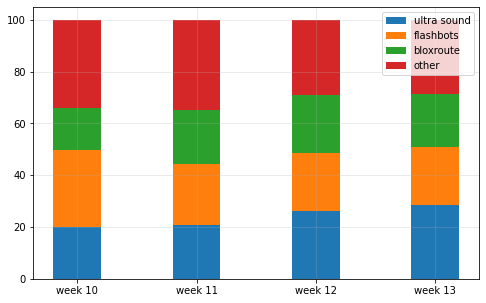

In [40]:
width = 0.5

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(4)

vals = np.swapaxes(dominance.values[:,1:], 0, 1)
ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom, label='ultra sound')
ax.bar(np.arange(4), vals[1], width=0.4, bottom=vals[0], label='flashbots')
ax.bar(np.arange(4), vals[2], width=0.4, bottom=vals[1]+vals[0], label='bloxroute')
ax.bar(np.arange(4), vals[3], width=0.4, bottom=vals[2]+vals[1]+vals[0], label='other')

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['week 10','week 11','week 12','week 13'])
# ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom)
# ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom)

# for v in dominance.values[:,1:]:
#     print(v)
#     p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

# ax.set_title("Number of penguins with above average body mass")
# ax.legend(loc="upper right")

plt.legend()
plt.show()